In [1]:
import torch
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import copy

matplotlib.rcParams['figure.facecolor']='#ffffff'

## GPU CONFIG

In [2]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
    
def to_device(data, device):
    #In you want to pass multiple tensors at the same time: data = [tensor1,tensor2...batch1, batch2....]
    if isinstance (data, (list,tuple)):
        return [to_device(x,device) for x in data]
    # This line is what makes the magic
    return data.to(device, non_blocking=True)

class DeviceDataLoader:
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        #Yield a batch of data after moving it to device
        for batch in self.dl:
            yield to_device(batch, self.device)
    
    def __len__(self):
        # Returns the number of batches
        return len(self.dl)
    

device = get_default_device()

## DATASETS

In [3]:
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder

train_tfms = tt.Compose([
    tt.Resize(300),
    tt.RandomHorizontalFlip(),
#    tt.ColorJitter(brightness=(0.5,1), contrast=(0.5,1)),
#    tt.RandomRotation((-8,8)),
    tt.ToTensor(),
])

validation_tfms = tt.Compose([
    tt.Resize(300),
    tt.ToTensor(),
])

train_ds = ImageFolder(root='/home/enrique/Documents/Projects/XCHEST14/DataInfo/XCHEST/subset/train', 
                      transform=train_tfms)
validation_ds = ImageFolder(root='/home/enrique/Documents/Projects/XCHEST14/DataInfo/XCHEST/subset/val', 
                      transform=validation_tfms)

## DATALOADERS

In [4]:
batch_size = 32

# Pytorch data loaders
from torch.utils.data.dataloader import DataLoader

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers = 4, pin_memory=True)
validation_dl = DataLoader(validation_ds, batch_size*2, shuffle=True, num_workers = 4, pin_memory=True)

In [6]:
# Pointing out the dataloaders to the GPU
train_dl = DeviceDataLoader(train_dl, device)
validation_dl = DeviceDataLoader(validation_dl, device)

## PRETRAINED FINE TUNING

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

model_ft =  models.inception_v3(pretrained=True)
model_ft.aux_logits=False 
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs,2)
to_device(model_ft, device)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

## TRAINING

In [8]:
class Helpers:
    def __init__(self, model):
        self.model = model
    
    #Validation Base Functions
    @staticmethod
    def accuracy(preds, labels):
        _, preds = torch.max(preds, dim=1)
        return torch.tensor(torch.sum(preds==labels).item()/len(preds)*100)
    
    def evaluate(self, val_loader):
        # Ignores certain layers, like dropout, during validation_step
        self.model.eval() # <--- This is important
        outputs = [self.validation_step(batch) for batch in val_loader]
        return outputs

    #Training Base Functions
    def training_step(self, xb):
        images, labels = xb
        preds = self.model(images)
        loss = F.cross_entropy(preds, labels)
        return loss
        
    def validation_step(self, batch):
        images, labels = batch
        with torch.no_grad():
            val_preds = self.model(images)
        loss = F.cross_entropy(val_preds, labels)
        acc = self.accuracy(val_preds, labels)
        return {'val_loss':loss, 'val_acc':acc}
    
    def epoch_summary(self,validation_preds, training_loss, lrs):
        training_batch_losses = [t for t in training_loss]
        epoch_training_loss = torch.stack(training_batch_losses).mean()
        val_batch_losses = [v["val_loss"] for v in validation_preds]
        epoch_val_loss = torch.stack(val_batch_losses).mean()
        batch_accs = [v["val_acc"] for v in validation_preds]
        epoch_val_acc = torch.stack(batch_accs).mean()
        return {
            "training_loss":epoch_training_loss,
            "validation_loss": epoch_val_loss,
            "accuracy":epoch_val_acc,
            "lr": lrs[-1]
        }

In [9]:
helper = Helpers(model_ft)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,helper, 
                  weight_decay = 0, grad_clip = None, opt_func = torch.optim.SGD):
    
    #Cleaning CUDA Cache
    torch.cuda.empty_cache()
    
    history = []

    # Set up optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay = weight_decay)
    
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader)
    )
    
    
    for epoch in range(epochs):
        #Training Phase
        model.train()
        epoch_training_loss=[]
        lrs = []
        
        for batch in train_loader:
            training_loss = helper.training_step(batch)
            epoch_training_loss.append(training_loss)
            training_loss.backward()
            
            #Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            #Record and update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
                
        #Validation
        validation_results = helper.evaluate(val_loader)
        epoch_summary = helper.epoch_summary(validation_results,epoch_training_loss, lrs)
        history.append(epoch_summary )
        print(f'''training_loss:{epoch_summary["training_loss"]}, validation_loss:{epoch_summary["validation_loss"]}, accuracy:{epoch_summary["accuracy"]}''')
        
    return history 


def showStats(history, numberOfEpochs):
    val_losses = [x["validation_loss"] for x in history]
    training_losses = [x["training_loss"] for x in history]
    accuracies = [x["accuracy"] for x in history]
    lrs = [x["lr"] for x in history]

    plot1 = plt.figure(1)
    plt.plot([x+1 for x in range(numberOfEpochs)],val_losses, "b")
    plt.plot([x+1 for x in range(numberOfEpochs)],training_losses, "r")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs Epochs')

    plot2 = plt.figure(2)
    plt.plot([x+1 for x in range(numberOfEpochs)],accuracies)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs Epochs')
    
    plot3 = plt.figure(3)
    plt.plot([x+1 for x in range(numberOfEpochs)],lrs)
    plt.xlabel('epoch')
    plt.ylabel('learning rate')
    plt.title('Learning Rate vs Epochs')

    plt.show()

training_loss:0.670503556728363, validation_loss:0.6400850415229797, accuracy:62.3100471496582
training_loss:0.627140462398529, validation_loss:0.6209104061126709, accuracy:65.03063201904297
training_loss:0.552703320980072, validation_loss:0.6368188261985779, accuracy:65.22671508789062


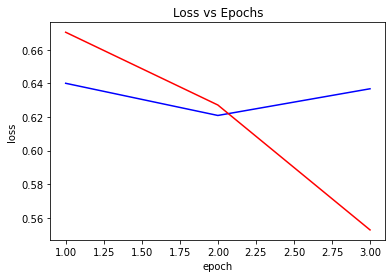

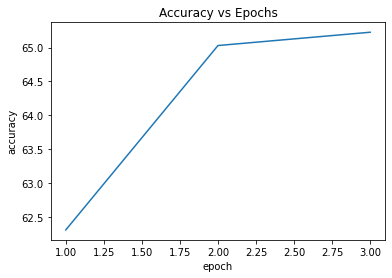

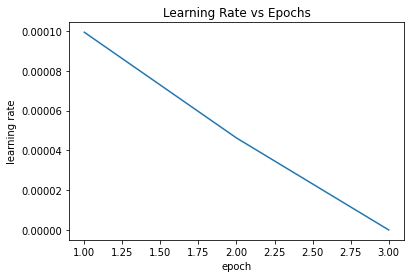

CPU times: user 6min 7s, sys: 3min 12s, total: 9min 19s
Wall time: 14min 46s


In [10]:
%%time

#Config 1
epochs = 3
max_lr = 0.0001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

history = fit_one_cycle(epochs, max_lr, model_ft, train_dl, validation_dl,helper,
                        grad_clip = grad_clip,
                        weight_decay = weight_decay,
                        opt_func=opt_func)

showStats(history, epochs)

torch.save(model_ft,'pulmonary_infiltration.pth')